In [1]:
import sys

sys.path.append('.')

import ntpath
import os
import tqdm
import torch
import numpy as np
import json

from collections import defaultdict
from torch.utils.data import DataLoader

from data.aug import ops
from data.dataset import DOTA
from data.aug.compose import Compose

from model.rdd import RDD
from model.backbone import resnet

from utils.box.bbox_np import xywha2xy4, xy42xywha
from utils.box.rbbox_np import rbbox_batched_nms
from utils.parallel import CustomDetDataParallel

In [2]:
def angle_diff(a1, a2):
    diff = a1-a2
    diff = abs((diff + 180) % 360 - 180)
    return diff

def create_dataset_from_folder(dir_dataset):
    pairs = []
    for filename in os.listdir(dir_dataset):
        img = os.path.join(dir_dataset, filename)
        anno = None
        pairs.append([img, anno])
    
    os.makedirs('image-sets', exist_ok=True)
    json.dump(pairs, open(os.path.join('image-sets', 'dataset.json'), 'wt'), indent=2)
    
dir_dataset = './images/test'
create_dataset_from_folder(dir_dataset)

In [3]:
dir_output = './predictions'
path_bar_predictions = os.path.join(dir_output, 'prediction.txt')
path_bar_predictions_drew_bbs = os.path.join(dir_output, 'bar_bbs/')
path_cropped_bars_predictions = os.path.join(dir_output, 'cropped_bars/')

In [4]:
batch_size = 12
num_workers = 4
conf_thresh = 0.4
nms_thresh = 0.4
image_size = 768
device_ids = [0]
torch.cuda.set_device(device_ids[0])

backbone = resnet.resnet101
indexes = [int(os.path.splitext(path)[0]) for path in os.listdir('save/weight/')]
current_step = max(indexes) if indexes else 0

dir_weight = os.path.join(f'save/weight/{current_step}.pth')
dir_weight

'save/weight/140100.pth'

In [5]:
aug = Compose([ops.PadSquare(), ops.Resize(image_size)])
dataset = DOTA('.', 'dataset', aug)
print(f'predicting {len(dataset)} files')

loader = DataLoader(dataset, batch_size, num_workers=num_workers, pin_memory=True, collate_fn=dataset.collate)
num_classes = len(dataset.names)

prior_box = {
    'strides': [8, 16, 32, 64, 128],
    'sizes': [3] * 5,
    'aspects': [[1, 2, 4, 8]] * 5,
    'scales': [[2 ** 0, 2 ** (1 / 3), 2 ** (2 / 3)]] * 5,
    'old_version': False
}
cfg = {
    'prior_box': prior_box,
    'num_classes': num_classes,
    'extra': 2,
    'conf_thresh': conf_thresh,
    'nms_thresh': nms_thresh
}

model = RDD(backbone(fetch_feature=True), cfg)
model.build_pipe(shape=[2, 3, image_size, image_size])
model.restore(dir_weight)
if len(device_ids) > 1:
    model = CustomDetDataParallel(model, device_ids)
model.cuda()
model.eval()

predicting 7245 files


RDD(
  (backbone): Backbone(
    (head): Sequential(
      (0): Conv2d(
        (module): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      )
      (1): BatchNorm2d(
        (module): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (body): Sequential(
          (0): Conv2d(
            (module): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (1): BatchNorm2d(
            (module): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (2): ReLU(inplace=True)
          (3): Conv2d(
            (module): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (4): BatchNorm2d(
            (module): BatchNorm2d(64, 

In [6]:
count_predicted, count_not_predicted = 0, 0
ret_raw = defaultdict(list)    
for images, targets, infos in tqdm.tqdm(loader):
    images = images.cuda() / 255
    dets = model(images)
    for (det, info) in zip(dets, infos):
        fname = ntpath.basename(info['img_path'])
        if det:
            count_predicted += 1
            bboxes, scores, labels = det
            bboxes = bboxes.cpu().numpy()
            scores = scores.cpu().numpy()
            labels = labels.cpu().numpy()
            x, y, w, h = 0, 0, info['shape'][1], info['shape'][0]
            x, y, w, h = int(x), int(y), int(w), int(h)
            long_edge = max(w, h)
            pad_x, pad_y = (long_edge - w) // 2, (long_edge - h) // 2
            bboxes = np.stack([xywha2xy4(bbox) for bbox in bboxes])
            bboxes *= long_edge / image_size
            bboxes -= [pad_x, pad_y]
            bboxes += [x, y]
            bboxes = np.stack([xy42xywha(bbox) for bbox in bboxes])
            ret_raw[fname].append([bboxes, scores, labels])
        else:
            count_not_predicted += 1
            ret_raw[fname].append([np.zeros((1,5)), np.zeros((1,)), np.zeros((1,))])
    if count_predicted + count_not_predicted > 100:
        break
print(f'{count_predicted} files with found object, {count_not_predicted} with no object found')

  1%|▏         | 8/604 [00:05<07:08,  1.39it/s]

32 files with found object, 76 with no object found


In [7]:
print('merging results...')
ret = []

for fname, dets in ret_raw.items():
    bboxes, scores, labels = zip(*dets)
    bboxes = np.concatenate(list(bboxes))
    scores = np.concatenate(list(scores))
    labels = np.concatenate(list(labels))
    keeps = rbbox_batched_nms(bboxes, scores, labels, nms_thresh)
    ret.append([fname, [bboxes, scores[keeps], labels[keeps]]])

print('converting to submission format...')
ret_save = defaultdict(list)
for fname, (bboxes, scores, labels) in ret:
    for bbox, score, label in zip(bboxes, scores, labels):
        #         bbox = xywha2xy4(bbox).ravel()
        line = '%s %.12f %.1f %.1f %.1f %.1f %.1f %s' % (fname, score, *bbox, str(label*5))
        ret_save[dataset.label2name[label]].append(line)

print('saving...')
os.makedirs(os.path.dirname(path_bar_predictions), exist_ok=True)
with open(os.path.join(path_bar_predictions), 'wt') as f:
    for name, dets in ret_save.items():
        for d in dets:
                f.write(''.join(d) + '\n')

print('finished')

merging results...
converting to submission format...
saving...
finished


177.8 175.0 177.8


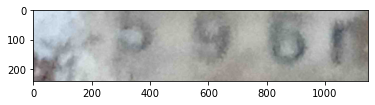

178.4 175.0 178.4


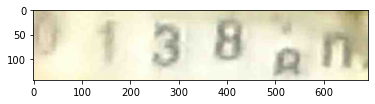

178.4 180.0 178.4


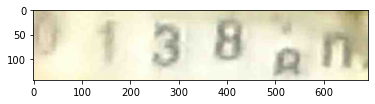

176.3 0.0 16.30000000000001


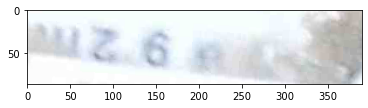

177.2 355.0 12.199999999999989


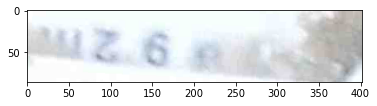

177.4 0.0 17.400000000000006


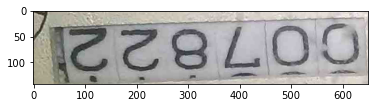

175.1 5.0 20.099999999999994


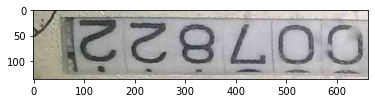

1.7 0.0 1.7


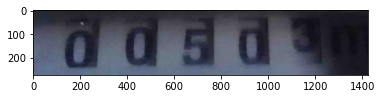

2.0 355.0 2.0


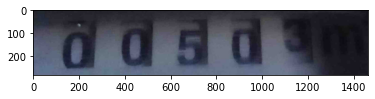

175.2 0.0 15.199999999999989


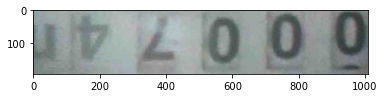

175.2 5.0 20.19999999999999


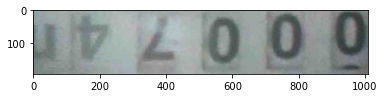

178.1 0.0 18.099999999999994


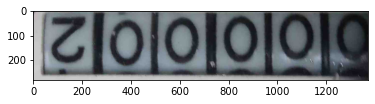

177.3 0.0 17.30000000000001


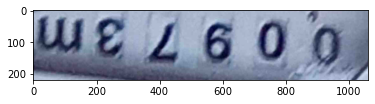

0.5 355.0 0.5


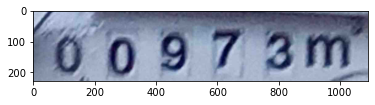

175.0 0.0 15.0


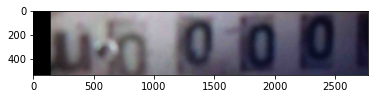

174.8 355.0 9.800000000000011


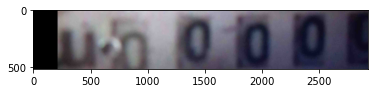

20.9 335.0 335.9


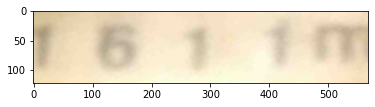

20.9 340.0 340.9


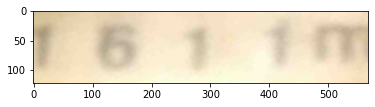

48.69999999999999 310.0 318.7


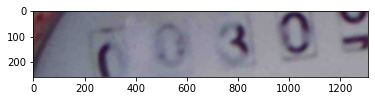

50.5 310.0 320.5


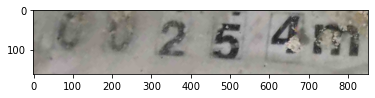

52.5 305.0 317.5


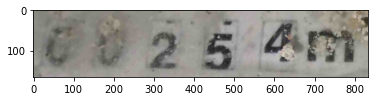

53.099999999999994 305.0 318.1


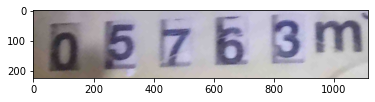

96.7 265.0 281.7


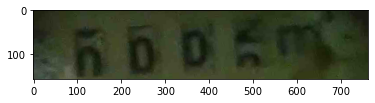

97.2 260.0 277.2


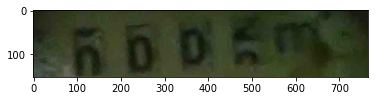

94.6 265.0 279.6


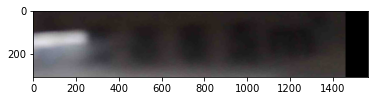

94.6 260.0 274.6


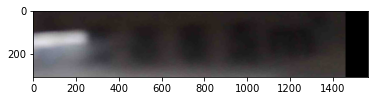

59.400000000000006 115.0 134.4


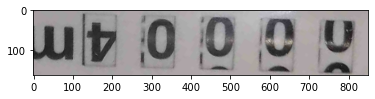

160.4 195.0 195.4


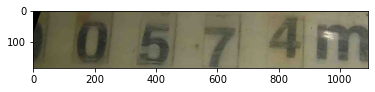

162.2 200.0 202.2


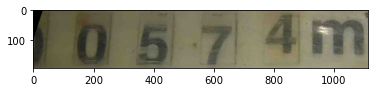

112.1 245.0 257.1


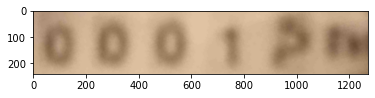

112.5 250.0 262.5


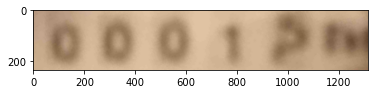

110.8 250.0 260.8


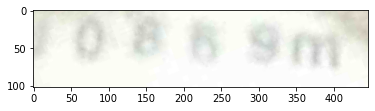

169.0 5.0 14.0


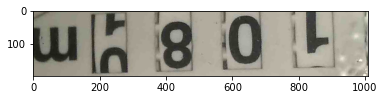

169.0 10.0 19.0


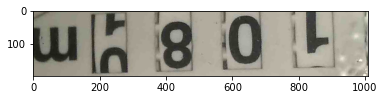

178.2 355.0 13.199999999999989


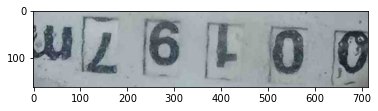

0.2 355.0 0.2


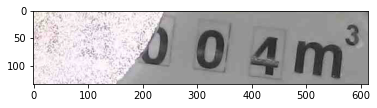

81.19999999999999 95.0 81.19999999999999


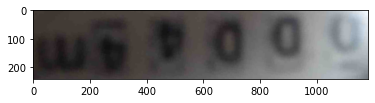

79.4 100.0 119.4


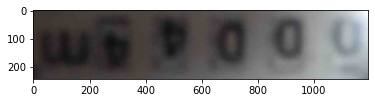

81.80000000000001 95.0 81.80000000000001


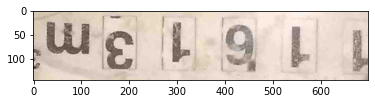

81.5 100.0 81.5


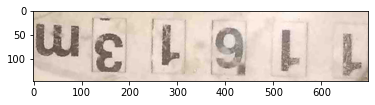

93.0 85.0 93.0


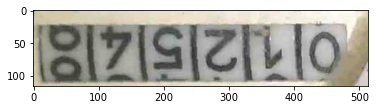

90.8 85.0 90.8


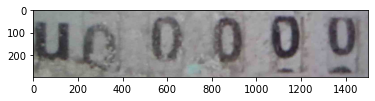

90.8 90.0 90.8


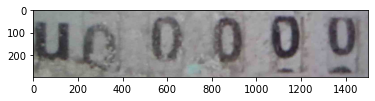

95.3 85.0 95.3


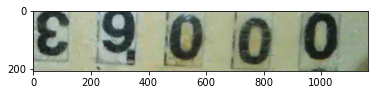

99.0 80.0 99.0


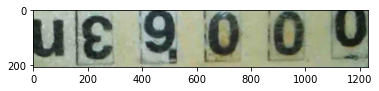

99.0 75.0 94.0


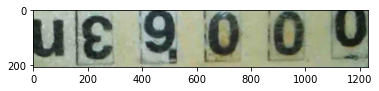

137.4 40.0 57.400000000000006


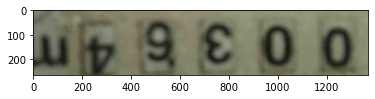

72.69999999999999 285.0 297.7


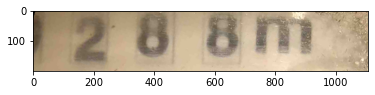

10.1 345.0 355.1


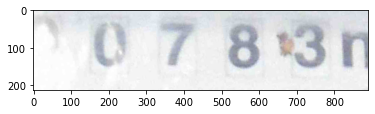

10.1 350.0 0.10000000000002274


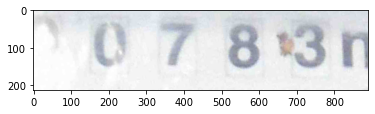

In [12]:
from PIL import Image, ImageDraw
import math 
import matplotlib.pyplot as plt

def rotate_around_point(point, radians, origin):
    x, y = point
    ox, oy = origin
    qx = ox + math.cos(radians) * (x - ox) + math.sin(radians) * (y - oy)
    qy = oy + -math.sin(radians) * (x - ox) + math.cos(radians) * (y - oy)
    return qx, qy

os.makedirs(path_bar_predictions_drew_bbs, exist_ok=True)
os.makedirs(os.path.dirname(path_cropped_bars_predictions), exist_ok=True)

with open(path_bar_predictions) as f:
    lines = f.readlines()
    predicted_bbs = dict()
    for i, l in enumerate(lines):
        parts = l.replace('\n','').split(' ')
        jpg_name = parts[0]
        bb = tuple(float(x) for x in parts[2:-1])
        angle = float(parts[-1])
        
        if jpg_name not in predicted_bbs:
            predicted_bbs[jpg_name] = []
        predicted_bbs[jpg_name].append((bb, angle))
    
    for jpg_name in predicted_bbs:
        img = Image.open(os.path.join(dir_dataset, jpg_name))
        default_img = img.copy()
        draw = ImageDraw.Draw(img)

        for i, (bb, angle_from_classification) in enumerate(predicted_bbs[jpg_name]):
            x, y, w, h, angle_from_bb = bb    
            coords = xywha2xy4(bb)
            if np.sum(coords):
                draw.line((*coords[0], *coords[1]), fill='red', width=20)
                draw.line((*coords[1], *coords[2]), fill='green', width=20)
                draw.line((*coords[2], *coords[3]), fill='blue', width=20)
                draw.line((*coords[3], *coords[0]), fill='yellow', width=20)

                width, height = img.size
                
                if w < h:
                    if coords[0][0] < coords[1][0]:
                        angle_from_bb += 90
                    else:
                        angle_from_bb -= 90
                    w, h = h, w
                
                t = 20
                angle =  angle_from_bb if angle_diff(angle_from_bb,angle_from_classification) < t \
                else (angle_from_classification + (angle_from_bb % t))%360
                print(angle_from_bb, angle_from_classification, angle)
                
                rotated_img = default_img.rotate(angle_from_bb)
#                 plt.imshow(np.hstack([default_img, rotated_img]))
#                 plt.show()
                x1, y1 = rotate_around_point((x,y), math.radians(angle_from_bb), (width//2, height//2))
                cropped_bar = rotated_img.crop((x1-w//2, y1-h//2, x1+w//2, y1+h//2))

#                 bar_jpg_name = f'{i}__{jpg_name}'
# #                 cropped_bar.save(os.path.join(path_cropped_bars_predictions, bar_jpg_name))
                plt.imshow(cropped_bar)
#                 plt.title(str(label)+":"+str(score) +":"+str(angle_from_bb) +' '+str(angle_from_classification))
                plt.show()
#         plt.imshow(img)
#         plt.show()
#         img.save(os.path.join(path_bar_predictio?s_drew_bbs, jpg_name))
        

In [ ]:
path_bar_predictions_drew_bbs, path_cropped_bars_predictions